# teex

### Evaluation of explanation quality: saliency maps

In this notebook, we are going to explore how we can use **teex** to compare image explanation methods.

## 1. Evaluating synthetic image data explanations

In this section, we are going to 
1. Generate image data with available g.t. explanations using the 'seneca' method.
2. Create and train a pytorch classifier that will learn to recognize the pattern in the images.
3. Generate explanations with some model agnostic methods and evaluate them w.r.t. the ground truth explanations.

In [ ]:
%pip install teex
%pip install captum
%pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import PIL
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from math import floor

from captum.attr import GradientShap, IntegratedGradients, Occlusion, DeepLift, Lime, GuidedBackprop, GuidedGradCam

from teex.saliencyMap.data import SenecaSM
from teex.saliencyMap.eval import saliency_map_scores

from teex._utils._arrays import _minmax_normalize_array

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1.1. Generating the data

In [3]:
cellH, cellW = 4, 4
imH, imW = 32, 32

generator = SenecaSM(imageH=imH, imageW=imW, 
                     cellH=cellH, cellW=cellW, 
                     nSamples=5000, randomState=7)

X, y, exps = generator[:]
pattern = generator.pattern

Text(0.5, 1.0, 'Explanation')

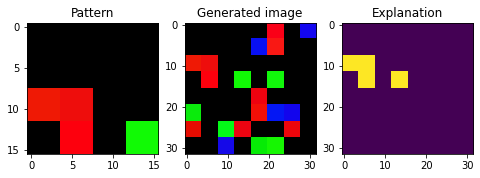

In [4]:
i = 2
fig, axs = plt.subplots(1, 3, figsize=(8, 8))
axs[0].imshow(pattern)
axs[0].set_title('Pattern')
axs[1].imshow(X[i])
axs[1].set_title('Generated image')
axs[2].imshow(exps[i])
axs[2].set_title('Explanation')

### 1.2. Declaring and training the model

Declare a simple LeNet variant and its training routine.

In [4]:
class FCNN(nn.Module):
    """ Basic NN for image classification. """

    def __init__(self, imH, imW, cellH, randomState=1):
        super(FCNN, self).__init__()
        stride = 1
        kSize = 5
        torch.manual_seed(randomState)
        self.conv1 = nn.Conv2d(3, 6, kernel_size=kSize, stride=stride)
        self.H1, self.W1 = floor(((imH - kSize) / stride) + 1), floor(((imW - kSize) / stride) + 1)
        self.conv2 = nn.Conv2d(6, 3, kernel_size=kSize, stride=stride)
        self.H2, self.W2 = floor(((self.H1 - kSize) / stride) + 1), floor(((self.W1 - kSize) / stride) + 1)
        self.conv3 = nn.Conv2d(3, 1, kernel_size=kSize, stride=stride)
        self.H3, self.W3 = floor(((self.H2 - kSize) / stride) + 1), floor(((self.W2 - kSize) / stride) + 1)
        self.fc1 = nn.Linear(self.H3 * self.W3, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        if len(x.shape) == 3:
            # single instance, add the batch dimension
            x = x.unsqueeze(0)
        x = nn.ReLU()(self.conv1(x))
        x = nn.ReLU()(self.conv2(x))
        x = nn.ReLU()(self.conv3(x))
        x = nn.ReLU()(self.fc1(x.view(x.shape[0], -1)))
        x = self.fc2(x)
        return x
    
import copy
# sample training function for classification
def train_net(model, data, criterion, optimizer, device, batchSize, nEpochs, randomState=888):
    """ data: dict with 'train' and 'val' entries. Each entry is a list with X: FloatTensor, y: LongTensor """
    torch.manual_seed(randomState)
    bestValAcc = -np.inf
    bestModelWeights = copy.deepcopy(model.state_dict())
    for epoch in range(nEpochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            lossVal = .0
            corrects = 0
            
            for batch in range(int(len(data[phase][0]) / batchSize)):
                XBatch = data[phase][0][batch:batch + batchSize].to(device)
                yBatch = data[phase][1][batch:batch + batchSize].to(device)
                
                model.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):

                    out = model(XBatch)
                    loss = criterion(out, yBatch)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    _, preds = torch.max(out, 1)
                
                lossVal += loss.item() * XBatch.size(0)
                corrects += torch.sum(preds == yBatch.data)
            
            epochLoss = lossVal / len(data[phase][0])
            epochAcc = corrects.double() / len(data[phase][0])
            print(f'{phase} Loss: {round(epochLoss, 4)} Acc: {round(epochAcc.item(), 4)}')
        
            if phase == 'val' and epochAcc > bestValAcc:
                bestValAcc = epochAcc
                bestModelWeights = copy.deepcopy(model.state_dict())
        
        model.load_state_dict(bestModelWeights)
        
    return model, bestValAcc

We cast the images to torch.Tensor type and get train, validation and test splits.

In [6]:
XTrain, XTest, yTrain, yTest, expsTrain, expsTest = train_test_split(X, y, exps, train_size=0.8, random_state=7)
XTrain, XVal, yTrain, yVal, expsTrain, expsVal = train_test_split(XTrain, yTrain, expsTrain, train_size=0.75, random_state=7)

XTrain = torch.FloatTensor(XTrain).permute(0, 3, 1, 2)
yTrain = torch.LongTensor(yTrain)
XVal = torch.FloatTensor(XVal).permute(0, 3, 1, 2)
yVal = torch.LongTensor(yVal)
XTest = torch.FloatTensor(XTest).permute(0, 3, 1, 2)
yTest = torch.LongTensor(yTest)

In [7]:
print(f'Data proportions -> Train: {round(len(XTrain) / len(X), 3)}, Val: {round(len(XVal) / len(X), 3)}, Test: {round(len(XTest) / len(X), 3)}')
print(f'Positive label proportions -> Train: {round((sum(yTrain) / len(yTrain)).item(), 3)}, \
Val: {round((sum(yVal) / len(yVal)).item(), 3)}, Test: {round((sum(yTest) / len(yTest)).item(), 3)}')

Data proportions -> Train: 0.6, Val: 0.2, Test: 0.2
Positive label proportions -> Train: 0.489, Val: 0.526, Test: 0.507


and train the network

In [ ]:
nFeatures = len(XTrain[0].flatten())
criterion = nn.CrossEntropyLoss()
model = FCNN(imH=32, imW=32, cellH=4)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
data = {'train': [XTrain, yTrain], 'val': [XVal, yVal]}

if torch.cuda.is_available():
    device = torch.device("cuda:0")

    model.to(device)
    data["train"] = [XTrain.to(device), yTrain.to(device)]
    data["val"] = [XVal.to(device), yVal.to(device)]
else:
    device = torch.device("cpu")

model, valAcc = train_net(model, data, criterion, optimizer, device, batchSize=10, nEpochs=10, randomState=7)

In [9]:
if torch.cuda.is_available():
    print(f'Validation F1: {round(f1_score(yVal, F.softmax(model(XVal.cuda()), dim=-1).cpu().argmax(dim=1).numpy()), 3)}')
    print(f'Test F1: {round(f1_score(yTest, F.softmax(model(XTest.cuda()), dim=-1).cpu().argmax(dim=1).numpy()), 3)}')
else:
    print(f'Validation F1: {round(f1_score(yVal, F.softmax(model(torch.FloatTensor(XVal)), dim=-1).argmax(dim=1).detach().numpy()), 3)}')
    print(f'Test F1: {round(f1_score(yTest, F.softmax(model(torch.FloatTensor(XTest)), dim=-1).argmax(dim=1).detach().numpy()), 3)}')

Validation F1: 0.988
Test F1: 0.983


### 1.3. Generating and evaluating explanations

With the model trained on the synthetic images, we generate explanations (with Captum, but feel free to use other methods!). First, declare the explainers:

In [10]:
layer = [layer for _, layer in model.named_modules()][-3]

gradShap = GradientShap(model)
intGrad = IntegratedGradients(model)
occlusion = Occlusion(model)
deepLift = DeepLift(model)
guidedBackProp = GuidedBackprop(model)
guidedGradCAM = GuidedGradCam(model, layer)

And define a function to obtain the explanations from different methods:

In [5]:
def get_attributions(data, targets, explainer, params=None):
    """  
    :param data: (Tensor) data to explain
    :param targets: (Tensor) class labels w.r.t which we want to compute the attributions
    :param explainer: (captum.attr method) initialised explainer
    :param params: (dict) parameters for the .attribute method of the explainer 
    :return: ndarray of shape with attributions
    """

    if params is None:
        params = {}
    elif "baselines" in params and type(params["baselines"]) != int:
        params["baselines"] = params["baselines"].to(device)
        
    attributions = []
    for image, target in zip(data, targets):
        attr = explainer.attribute(image.unsqueeze(0), target=target, **params).cpu().squeeze().detach().numpy()
        # mean pool channel attributions
        attr = np.mean(attr, axis=0)
        # viz._normalize_image_attr(tmp, 'absolute_value', 10)
        attributions.append(_minmax_normalize_array(attr))

    return np.array(attributions)

In [ ]:
# use predicted labels
obsToExplain = torch.FloatTensor(XTest[:5]).to(device)
expsToCompare = expsTest[:5]
predTargets = F.softmax(model(obsToExplain), dim=-1).argmax(dim=1)[:5].to(device)
z = torch.LongTensor([1 if e == 0 else 0 for e in predTargets])
# z = torch.zeros(len(predTargets), dtype=torch.int)

In [ ]:
# takes some minutes to run
gradShapExpsTest = get_attributions(obsToExplain, predTargets, gradShap, {'baselines': torch.zeros((1, 3, imH, imW))})
intGradExpsTest = get_attributions(obsToExplain, predTargets, intGrad)
deepLiftExpsTest = get_attributions(obsToExplain, predTargets, deepLift)
occlusionExpsTest = get_attributions(obsToExplain, predTargets, occlusion, {'baselines': 0, 'sliding_window_shapes': (3, cellH*2, cellW*2)})
gBackPropExpsTest = get_attributions(obsToExplain, z, guidedBackProp)
gGradCAMExpsTest = get_attributions(obsToExplain, z, guidedGradCAM)

with open('expsSynth.pickle', 'wb') as handle:
    pickle.dump([gradShapExpsTest, intGradExpsTest, deepLiftExpsTest, occlusionExpsTest, gBackPropExpsTest, gGradCAMExpsTest], handle)

In [ ]:
with open('expsSynth.pickle', 'rb') as handle:
    gradShapExpsTest, intGradExpsTest, deepLiftExpsTest, occlusionExpsTest,\
        gBackPropExpsTest, gGradCAMExpsTest = pickle.load(handle)

Text(0.5, 1.0, 'Guided gradCAM.')

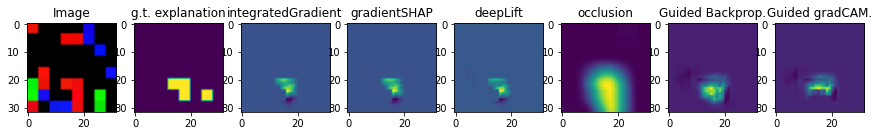

In [ ]:
i = 3

fig, axs = plt.subplots(1, 8, figsize=(15,15))
axs[0].imshow(obsToExplain[i].cpu().permute(1, 2, 0))
axs[0].set_title('Image')
axs[1].imshow(expsToCompare[i])
axs[1].set_title('g.t. explanation')
axs[2].imshow(intGradExpsTest[i])
axs[2].set_title('integratedGradient')
axs[3].imshow(gradShapExpsTest[i])
axs[3].set_title('gradientSHAP')
axs[4].imshow(deepLiftExpsTest[i])
axs[4].set_title('deepLift')
axs[5].imshow(occlusionExpsTest[i])
axs[5].set_title('occlusion')
axs[6].imshow(gBackPropExpsTest[i])
axs[6].set_title('Guided Backprop.')
axs[7].imshow(gGradCAMExpsTest[i])
axs[7].set_title('Guided gradCAM.')

And we can evaluate the explanations. We set the binarization threshold for the generated explanations to 0.5 because we only want high values to count.

In [ ]:
metrics = ['auc', 'fscore', 'prec', 'rec', 'cs']
gradShapScores = saliency_map_scores(expsTest[yTest == 1], gradShapExpsTest, metrics=metrics, binThreshold=0.5)
intGradScores = saliency_map_scores(expsTest[yTest == 1], intGradExpsTest, metrics=metrics, binThreshold=0.5)
deepLiftScores = saliency_map_scores(expsTest[yTest == 1], deepLiftExpsTest, metrics=metrics, binThreshold=0.5)
occlusionScores = saliency_map_scores(expsTest[yTest == 1], occlusionExpsTest, metrics=metrics, binThreshold=0.5)
gBackPropScores = saliency_map_scores(expsTest[yTest == 1], gBackPropExpsTest, metrics=metrics, binThreshold=0.5)
gGradCAMScores = saliency_map_scores(expsTest[yTest == 1], gGradCAMExpsTest, metrics=metrics, binThreshold=0.5)

scores = pd.DataFrame(data=[gradShapScores, intGradScores, deepLiftScores, 
                            occlusionScores, gBackPropScores, gGradCAMScores], columns=metrics)
scores['technique'] = ['gradSHAP', 'intGrad', 'deepLift', 'occlusion', 'guidedBackProp', 'guidedGradCAM']
scores

Note how the warnings tell us that the predictions from one of the techniques did not contain any relevant values. 

From here, we can build a more complex explanation evaluation pipeline. Suppose that, given some explainer architecture and model, we want to measure how the influence of some explainer hyperparameters influence the quality of their generated explanations.

In [6]:
def eval_explainers(
        explainers, 
        explainerConfigs, 
        data, 
        targets, 
        trueExps, 
        metrics, 
        binThreshold: float = .5) -> dict:
    """ 
    :param explainers: (dict of captum.attr explainers) explainers to use
    :param explainerConfigs: (dict of list of dict) hyperparameter values to use for each explainer (see Captum docs)
    :param data: (Tensor) data to explain
    :param targets: (Tensor) labels w.r.t. which we compute the explanations
    :param trueExps: (ndarray) ground truth explanations
    :param metrics: (array-like of str) metrics to compute
    :param float binThreshold: threshold to use when binarizing for the computation of classification metrics.
    """
    allScores = {explainer: {met: [] for met in metrics} for explainer in explainers.keys()}
    for explainerName, explainer in explainers.items():
        for config in explainerConfigs[explainerName]:
            exps = get_attributions(data, targets, explainer, config)
            evals = saliency_map_scores(trueExps, exps, metrics=metrics, binThreshold=binThreshold)
            for i, score in enumerate(evals):
                allScores[explainerName][metrics[i]].append(score)
    return allScores

for example, given these gradSHAP and guidedGradCAM configurations:

In [ ]:
configs = {
    'gradSHAP': [{'baselines': torch.zeros((1, 3, imH, imW)), 'n_samples': 10, 'stdevs': 0.1},
                 {'baselines': torch.zeros((1, 3, imH, imW)), 'n_samples': 15, 'stdevs': 0.15}],
    'gradCAM': [{'interpolate_mode': 'nearest'},
                {'interpolate_mode': 'area'}]
}

explainers = {'gradSHAP': gradShap, 'gradCAM': guidedGradCAM}

metrics = ['auc', 'fscore', 'prec', 'rec', 'cs']

In [ ]:
# takes some minutes to run
scores = eval_explainers(explainers, configs, XTest[yTest==1].to(device), yTest[yTest==1], expsTest[yTest==1], metrics)

with open('synthScores.pickle', 'wb') as f:
    pickle.dump(scores, f)

In [ ]:
with open('synthScores.pickle', 'rb') as f:
    scores = pickle.load(f)

For each explainer and configuration, we have a score:

In [ ]:
scores

{'gradSHAP': {'auc': [0.7992577, 0.80201876],
  'fscore': [0.5050217, 0.5090714],
  'prec': [0.9954608, 0.9955106],
  'rec': [0.34479782, 0.3487118],
  'cs': [0.39023715, 0.3968119]},
 'gradCAM': {'auc': [0.34990147, 0.31682178],
  'fscore': [0.1094004, 0.11006599],
  'prec': [0.05815248, 0.058509283],
  'rec': [0.9214127, 0.92628205],
  'cs': [0.23264565, 0.23132235]}}

With these metrics, then, we can evaluate the performance of explainers.

## 2. Evaluating Kahikatea image explanations

teex includes real datasets with available ground truth explanations. For example, the Kahikatea dataset contains 519 images, and the task is to tell whether each observation contains Kahikatea trees or not. There are 232 positive observations and 287 negative ones.

In teex, the non-artificial datasets are implemented as classes, similarly to PyTorch. After instancing the class, the data itself will be downloaded if it has not been used before. Once done, one can slice it to obtain observations. Each observation contains the data point, the label and the ground truth explanation.

In [7]:
from teex.saliencyMap.data import Kahikatea

In [8]:
nClasses = 2
kahikateaData = Kahikatea()
kData, kLabels, kExps = kahikateaData[:]

Files do not exist or are corrupted:


142303232it [00:43, 3241716.65it/s]                               


Text(0.5, 1.0, 'g.t. explanation')

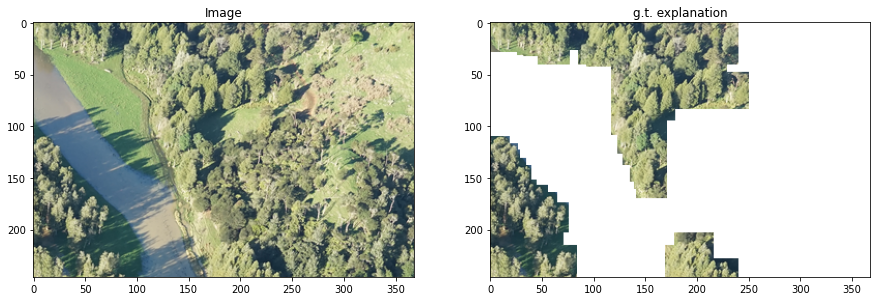

In [9]:
i = 0
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(kData[i])
axs[0].set_title('Image')
axs[1].imshow(kExps[i])
axs[1].set_title('g.t. explanation')

In [10]:
kahikateaData.classMap

{0: 'Not in image', 1: 'In image'}

Let's fine-tune a pre-trained squeezenet for our particular task.

In [34]:
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True  # 
sqznet = torch.hub.load('pytorch/vision:v0.9.0', 'squeezenet1_0', pretrained=True, progress=False)
torch.manual_seed(7)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


And modify its architecture so the shape of the output conforms to our 2-class problem instead of the 1000-class ImageNet.

In [35]:
sqznet.classifier[1] = nn.Conv2d(512, nClasses, kernel_size=(1,1), stride=(1,1))
sqznet.num_classes = nClasses
inputSize = 224

Define the required transform for the input images

In [13]:
from torchvision import transforms

inputTransform = transforms.Compose([transforms.Resize((inputSize, inputSize)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
resizeTransform = transforms.Compose([transforms.Resize((inputSize, inputSize)),
                                     transforms.ToTensor()])

Transform the data to torch tensors and create the splits:

In [14]:
kData = torch.stack([inputTransform(img) for img in kData])
kExps = torch.stack([resizeTransform(img) if isinstance(img, PIL.Image.Image) else torch.zeros((3, inputSize, inputSize)) for img in kExps]).permute(0, 2, 3, 1)
kExps = kExps.numpy().astype(np.float32)  # we need g.t. explanations to be numpy arrays for the evaluation
kLabels = torch.LongTensor(kLabels)

kTrain, kTest, kTrainLabels, kTestLabels, kExpsTrain, kExpsTest = train_test_split(kData, kLabels, kExps, train_size=0.8, random_state=7)
kTrain, kVal, kTrainLabels, kValLabels, kExpsTrain, kExpsVal = train_test_split(kTrain, kTrainLabels, kExpsTrain, train_size=0.75, random_state=7)

In [15]:
print(f'Data proportions -> Train: {round(len(kTrain) / len(kData), 3)}, Val: {round(len(kVal) / len(kData), 3)}, Test: {round(len(kTest) / len(kData), 3)}')
print(f'Positive label proportions -> Train: {round((sum(kTrainLabels) / len(kTrainLabels)).item(), 3)}, \
Val: {round((sum(kValLabels) / len(kValLabels)).item(), 3)}, Test: {round((sum(kTestLabels) / len(kTestLabels)).item(), 3)}')

Data proportions -> Train: 0.599, Val: 0.2, Test: 0.2
Positive label proportions -> Train: 0.444, Val: 0.519, Test: 0.385


In [ ]:
opt = optim.SGD(sqznet.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batchSize = 10
nEpochs = 25
data = {'train': [kTrain.to(device), kTrainLabels.to(device)], 'val': [kVal.to(device), kValLabels.to(device)]}

sqznet.to(device)

sqznet, valAcc = train_net(sqznet, data, crit, opt, device, batchSize, nEpochs, randomState=7)

with open('sqznetTrained.pickle', 'wb') as f:
    pickle.dump(sqznet.state_dict(), f)

In [38]:
with open('sqznetTrained.pickle', 'rb') as f:
    sqznet.load_state_dict(pickle.load(f))

In [37]:
print(f'Validation F1: {round(f1_score(kValLabels, F.softmax(sqznet(kVal.to(device)), dim=-1).cpu().argmax(dim=1).detach().numpy()), 3)}')
print(f'Test F1: {round(f1_score(kTestLabels, F.softmax(sqznet(kTest.to(device)), dim=-1).cpu().argmax(dim=1).detach().numpy()), 3)}')

Validation F1: 0.816
Test F1: 0.643


Let us get some explanations as samples

In [77]:
back_hook = 'register_full_backward_hook' if torch.__version__ >= '1.8.0' else 'register_backward_hook'

gradShap = GradientShap(sqznet)
intGrad = IntegratedGradients(sqznet)
occlusion = Occlusion(sqznet)
deepLift = DeepLift(sqznet)
guidedBackProp = GuidedBackprop(sqznet)
guidedGradCAM = GuidedGradCam(sqznet, sqznet.features[12])

# use predicted labels
obsToExplain = torch.FloatTensor(kTest[kTestLabels == 1][:2]).to(device)
expsToCompare = kExpsTest[kTestLabels == 1][:2]
predTargets = F.softmax(sqznet(obsToExplain), dim=-1).argmax(dim=1)

# takes some minutes to run
gradShapExpsTest = get_attributions(obsToExplain, predTargets, gradShap, {'baselines': torch.zeros((1, 3, inputSize, inputSize))})
intGradExpsTest = get_attributions(obsToExplain, predTargets, intGrad)
deepLiftExpsTest = get_attributions(obsToExplain, predTargets, deepLift)
occlusionExpsTest = get_attributions(obsToExplain, predTargets, occlusion, {'baselines': 0, 'sliding_window_shapes': (3, inputSize, round(inputSize))})
gBackPropExpsTest = get_attributions(obsToExplain, predTargets, guidedBackProp)
gGradCAMExpsTest = get_attributions(obsToExplain, predTargets, guidedGradCAM)

/opt/conda/lib/python3.7/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:65: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


Text(0.5, 1.0, 'Guided gradCAM.')

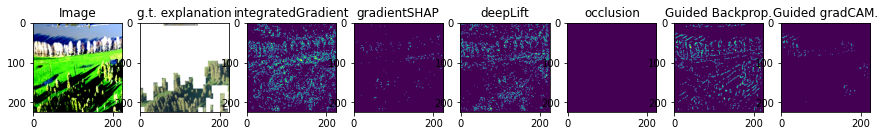

In [43]:
# we binarize the results for easier visualization (this step is implicitly done by teex)
#   when computing metrics.
from teex._utils._arrays import _binarize_arrays

gsh = _binarize_arrays(gradShapExpsTest, method='abs', threshold=0.55)
ig = _binarize_arrays(intGradExpsTest, method='abs', threshold=0.55)
dl = _binarize_arrays(deepLiftExpsTest, method='abs', threshold=0.55)
oc = _binarize_arrays(occlusionExpsTest, method='abs', threshold=0.55)
gbp = _binarize_arrays(gBackPropExpsTest, method='abs', threshold=0.55)
ggc = _binarize_arrays(gGradCAMExpsTest, method='abs', threshold=0.55)

i = 0

fig, axs = plt.subplots(1, 8, figsize=(15,15))
axs[0].imshow(obsToExplain[i].cpu().permute(1, 2, 0))
axs[0].set_title('Image')
axs[1].imshow(expsToCompare[i])
axs[1].set_title('g.t. explanation')
axs[2].imshow(ig[i])
axs[2].set_title('integratedGradient')
axs[3].imshow(gsh[i])
axs[3].set_title('gradientSHAP')
axs[4].imshow(dl[i])
axs[4].set_title('deepLift')
axs[5].imshow(oc[i])
axs[5].set_title('occlusion')
axs[6].imshow(gbp[i])
axs[6].set_title('Guided Backprop.')
axs[7].imshow(ggc[i])
axs[7].set_title('Guided gradCAM.')

From this visualization, it is clear that the threshold level is an important hyperparameter to consider.

Now, let's evaluate the quality of the explanations:

In [66]:
kExplainers = {'gradSHAP': GradientShap(sqznet), 
               'gradCAM': GuidedGradCam(sqznet, sqznet.features[12]),
               'deepLift': DeepLift(sqznet),
               'backProp': GuidedBackprop(sqznet),
               'occlusion': Occlusion(sqznet),
               'intGrad': IntegratedGradients(sqznet)}

kConfigs = {
    'gradSHAP': [{'baselines': torch.zeros((1, 3, inputSize, inputSize)), 'n_samples': 5, 'stdevs': 0.1}],
    'gradCAM': [{'interpolate_mode': 'nearest'}],
    'deepLift': [{}],
    'backProp': [{}],
    'occlusion': [{'baselines': 0, 'sliding_window_shapes': (3, round(inputSize), round(inputSize))}],
    'intGrad': [{'method': 'riemann_trapezoid'}]
}

metrics = ['auc', 'fscore', 'prec', 'rec', 'cs']

binThresholds = [e / 100 for e in range(10, 70, 5)]

Evaluate positive test explanations. Note that teex implicitly handles the conversion of the RGB masks into 0-1 normalised grayscale masks (the shape of the g.t.s need to be (imH, imW, 3) for it to happen).

In [67]:
# use predicted labels
obsToExplain = torch.FloatTensor(kTest[kTestLabels == 1]).to(device)
expsToCompare = kExpsTest[kTestLabels == 1]
predTargets = F.softmax(sqznet(obsToExplain), dim=-1).argmax(dim=1)

In [ ]:
# comparison to ground truth explanations
resGT = {}
for binThres in binThresholds:
    # takes a few minutes to run
    scoresK = eval_explainers(kExplainers, kConfigs, obsToExplain, predTargets, 
                              expsToCompare, metrics, binThreshold=binThres)
    resGT[f"{binThres}"] = scoresK
    # fileName = f'kahikateaScoresThres{binThres}.pickle'
    # with open(fileName, 'wb') as f:
    #     pickle.dump(scoresK, f)

with open("kahikateaScores", 'wb') as f:
    pickle.dump(resGT, f)

In [ ]:
resGT

In [ ]:
# comparison to integrated gradients explanations
obsToExplain = torch.FloatTensor(kTest[kTestLabels == 1]).to(device)
predTargets = F.softmax(sqznet(obsToExplain), dim=-1).argmax(dim=1)

expsToCompare = get_attributions(obsToExplain, predTargets, intGrad)

resIntGrad = {}
for binThres in binThresholds:
    # takes a few minutes to run
    scoresK = eval_explainers(kExplainers, kConfigs, obsToExplain, predTargets, 
                              expsToCompare, metrics, binThreshold=binThres)
    resIntGrad[f"{binThres}"] = scoresK

with open("kahikateaScores", 'wb') as f:
    pickle.dump(resIntGrad, f)

In [ ]:
resIntGrad

<p float="left">
  <img src="https://taiao.ai/assets/TAIAO_logo.png" alt="drawing" style="width:150px;"/>
  <img src="https://www.bourses-etudiants.ma/wp-content/uploads/2018/06/University-of-Waikato-logo.png" alt="drawing" style="width:150px;"/>
  <img src="https://www.upc.edu/comunicacio/ca/identitat/descarrega-arxius-grafics/fitxers-marca-principal/upc-positiu-p3005.png" alt="drawing" style="width:200px;"/>
</p>